In [1]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", SettingWithCopyWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import jax
import functools
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import flax.linen as nn
import optax
import cellflow
from cellflow.model import CellFlow
import cellflow.preprocessing as cfpp
from cellflow.utils import match_linear
from cellflow.plotting import plot_condition_embedding
from cellflow.preprocessing import transfer_labels, compute_wknn, centered_pca, project_pca, reconstruct_pca
from cellflow.metrics import compute_r_squared, compute_e_distance
from cellflow.networks._marginal_mlp import MLPMarginal

c:\Users\anike\anaconda3\envs\cellflow311\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\anike\anaconda3\envs\cellflow311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata_full = cellflow.datasets.zesta()
adata_full = adata_full[adata_full.obs["tissue"] == "Central Nervous System"]
adata = adata_full[:100000].copy()

In [3]:
mask_full = ~adata_full.obs["is_control"].to_numpy()
adata_criteria = adata_full[mask_full].copy()


adata_criteria = adata_criteria[~adata_criteria.obs_names.isin(adata.obs_names)]


adata = ad.concat([adata, adata_criteria])

In [4]:
np.random.seed(42)
random_indices = np.random.choice(adata.n_obs, size=70000, replace=False)
adata = adata_full[random_indices].copy()

In [5]:
adata.uns = adata_full.uns.copy()

In [ ]:
sc.pp.neighbors(adata, use_rep="X_aligned")
sc.tl.umap(adata)

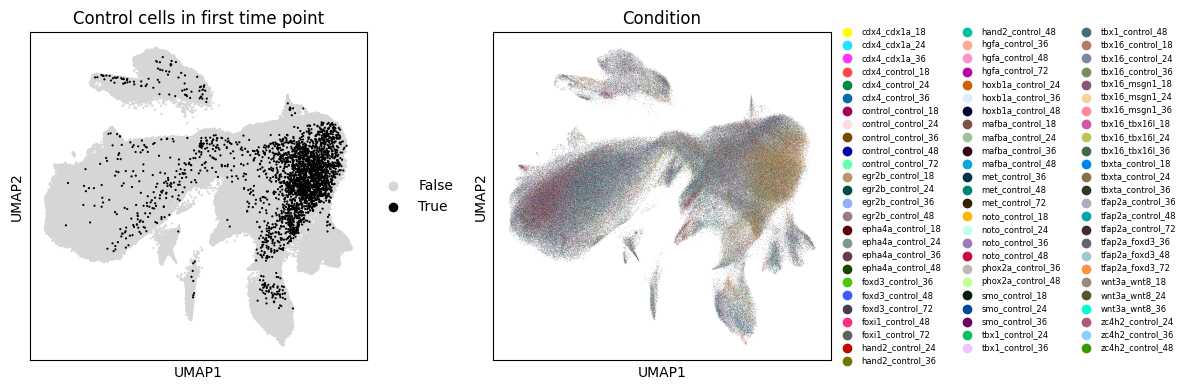

In [5]:
order = list(adata[~adata.obs["first_t_control"].to_numpy()].obs_names) + list(adata[adata.obs["first_t_control"].to_numpy()].obs_names)
adata.obs["first_t_control_str"] = adata.obs["first_t_control"].astype(str)

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Highlight first_t_control
sc.pl.umap(
    adata[order], 
    color="first_t_control_str", 
    size=10, 
    title="Control cells in first time point",
    palette={"True": "#000000", "False": "#D6D6D6"},
    show=False,
    ax=axs[0]
)

# Plot 2: Show condition
sc.pl.umap(
    adata, 
    color="condition", 
    title="Condition",
    show=False,
    ax=axs[1],
    legend_fontsize=6
)

plt.tight_layout()
plt.show()

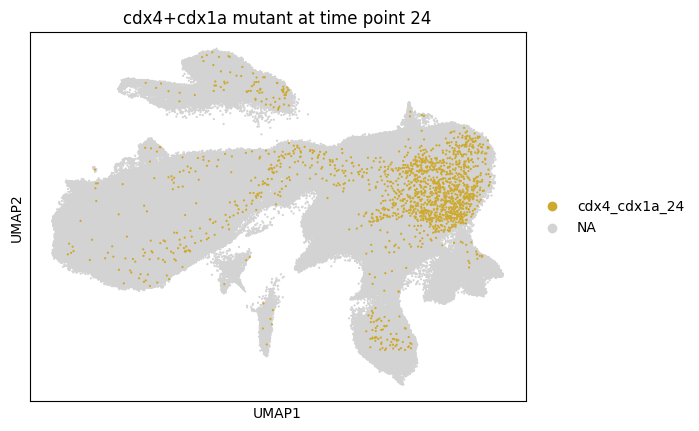

In [6]:
custom_palette = {k: "#D6D6D6" for k in adata.obs["condition"].unique()}
custom_palette.update({"cdx4_cdx1a_24": "#CEA92D"})
order = list(adata[adata.obs["condition"] != "cdx4_cdx1a_24"].obs_names) + \
        list(adata[adata.obs["condition"] == "cdx4_cdx1a_24"].obs_names)

sc.pl.umap(
    adata[order],
    color="condition",
    groups=["cdx4_cdx1a_24"],
    palette=custom_palette,
    title="cdx4+cdx1a mutant at time point 24",
    size=10,
)


In [6]:
adata_train = adata[adata.obs["condition"]!="cdx4_cdx1a_24"].copy()
adata_test = adata[(adata.obs["condition"]=="cdx4_cdx1a_24") | (adata.obs["condition"]=="control_control_18")].copy()
adata_train.n_obs, adata_test.n_obs

(69798, 2197)

In [7]:
cf = CellFlow(adata_train, solver="otfm")
cf_added = CellFlow(adata_train, solver="otfm")

In [8]:
prepare_data_args = {
    "sample_rep": "X_aligned",
    "control_key": "first_t_control",
    "perturbation_covariates": {"genetic_perturbation": ("gene_target_1" , "gene_target_2")},
    "perturbation_covariate_reps": {"genetic_perturbation": "gene_embeddings"},
    "sample_covariates": ("logtime",),
    "split_covariates": None,
    "max_combination_length": 2,
    "null_value": 0.0,
}

prepare_validation_args_train = {
    "adata": adata_train[:64],
    "name": "train",
    "n_conditions_on_log_iteration": None,
    "n_conditions_on_train_end": None,
}

prepare_validation_args_test = {
    "adata": adata_test,
    "name": "test",
    "n_conditions_on_log_iteration": None,
    "n_conditions_on_train_end": None,
}


cf.prepare_data(**prepare_data_args)
cf_added.prepare_data(**prepare_data_args)

cf.prepare_validation_data(**prepare_validation_args_train)
cf_added.prepare_validation_data(**prepare_validation_args_train)

cf.prepare_validation_data(**prepare_validation_args_test)
cf_added.prepare_validation_data(**prepare_validation_args_test)

100%|██████████| 2/2 [00:00<00:00, 334.11it/s]


In [9]:
layers_before_pool = {
    "genetic_perturbation": {"layer_type": "mlp", "dims": [128, 128], "dropout_rate": 0.0},
    "logtime": {"layer_type": "mlp", "dims": [128, 128], "dropout_rate": 0.0},
}

layers_after_pool = {
    "layer_type": "mlp", "dims": [256, 256], "dropout_rate": 0.0,
}

match_fn = functools.partial(match_linear, epsilon=0.5, tau_a=1.0, tau_b=1.0)

In [10]:
mlp_eta = MLPMarginal(128, 5)
mlp_xi = MLPMarginal(128, 5)

In [11]:
prepare_model_args_added = {
    "condition_mode": "deterministic",
    "regularization": 0.0,
    "pooling": "attention_token",
    "layers_before_pool": layers_before_pool,
    "layers_after_pool": layers_after_pool,
    "condition_embedding_dim": 256,
    "cond_output_dropout": 0.9,
    "hidden_dims": [512,512, 512],
    "decoder_dims": [512,512,512],
    "probability_path": {"constant_noise": 0.5},
    "match_fn": match_fn,
}
  
cf.prepare_model(**prepare_model_args_added)

prepare_model_args_added = prepare_model_args_added.copy()
prepare_model_args_added["mlp_eta"] = mlp_eta
prepare_model_args_added["mlp_xi"] = mlp_xi

cf_added.prepare_model(
    **prepare_model_args_added,
)

In [12]:
metrics_callback = cellflow.training.Metrics(metrics=["mmd", "e_distance"])
callbacks = [metrics_callback]

In [13]:
cf.train(
        num_iterations=200,
        batch_size=128,
        callbacks=callbacks,
        valid_freq=50,
    )

100%|██████████| 200/200 [48:49<00:00, 14.65s/it, loss=6.99]   


In [33]:
metrics_callback_added = cellflow.training.MetricsWithAddedLoss(metrics=["mmd", "e_distance"])
callbacks = [metrics_callback_added]
cf_added.train(
        num_iterations=200,
        batch_size=128,
        callbacks=callbacks,
        valid_freq=50,
    )

100%|██████████| 200/200 [57:59<00:00, 17.40s/it, loss=1.19e+6]   


In [34]:
cf_added.trainer.training_logs.keys()

dict_keys(['loss', 'train_mmd_mean', 'test_mmd_mean', 'train_e_distance_mean', 'test_e_distance_mean', 'loss_eta', 'loss_xi'])

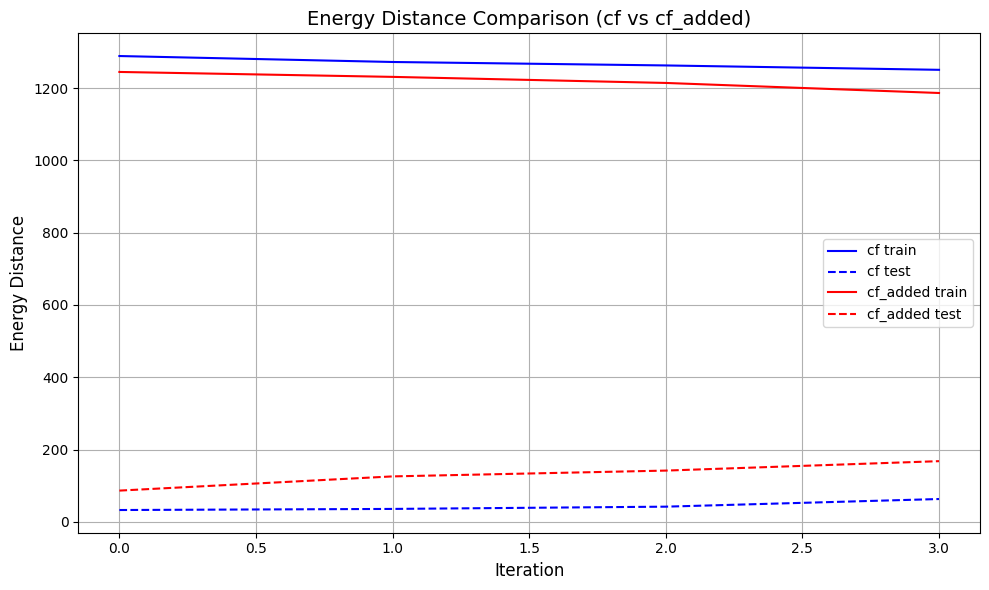

In [ ]:
e_distances_train_cf = cf.trainer.training_logs["train_e_distance_mean"]
e_distances_test_cf = cf.trainer.training_logs["test_e_distance_mean"]
e_distances_train_cf_added = cf_added.trainer.training_logs["train_e_distance_mean"]
e_distances_test_cf_added = cf_added.trainer.training_logs["test_e_distance_mean"]

iterations_train_cf = np.arange(len(e_distances_train_cf))
iterations_test_cf = np.arange(len(e_distances_test_cf))
iterations_train_cf_added = np.arange(len(e_distances_train_cf_added))
iterations_test_cf_added = np.arange(len(e_distances_test_cf_added))

fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(iterations_train_cf, e_distances_train_cf, linestyle='-', color='blue', label='cf train')
ax.plot(iterations_test_cf, e_distances_test_cf, linestyle='--', color='blue', label='cf test')


ax.plot(iterations_train_cf_added, e_distances_train_cf_added, linestyle='-', color='red', label='cf_added train')
ax.plot(iterations_test_cf_added, e_distances_test_cf_added, linestyle='--', color='red', label='cf_added test')


ax.set_title('Energy Distance Comparison (cf vs cf_added)', fontsize=14)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Energy Distance', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.show()

Predicting

In [37]:
covariate_data_train = adata_train[~adata_train.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])
covariate_data_test = adata_test[~adata_test.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])

In [38]:
print(covariate_data_test.shape)
print(covariate_data_test["condition"].unique())

(1, 36)
['cdx4_cdx1a_24']
Categories (1, object): ['cdx4_cdx1a_24']


In [39]:
print(adata_test.obs["is_control"].value_counts())

is_control
True     1995
False     202
Name: count, dtype: int64


In [40]:
def duplicate_and_interpolate(df, column, start, end, steps):
    result = pd.DataFrame()
    
    for _, row in df.iterrows():
        new_rows = pd.DataFrame([row] * steps)  # Duplicate the row
        new_rows[column] = np.log(np.linspace(start, end, steps)) # Log-transform the time point
        result = pd.concat([result, new_rows], ignore_index=True)
    
    return result
    
covariate_data_interpolated = duplicate_and_interpolate(covariate_data_test, 'logtime', 18, 36, 10)
covariate_data_interpolated.loc[:, "condition"] = covariate_data_interpolated.apply(lambda x: "_".join([x.gene_target, str(int(np.round(np.exp(x.logtime))))]), axis=1)
covariate_data_interpolated.head()


,cell,Size_Factor,n.umi,perc_mitochondrial_umis,timepoint,Oligo,hash_umis,top_to_second_best_ratio,cell_type_sub,cell_type_broad,...,hash_plate,log.hash_umis,gene1+gene2,gene_target_1,gene_target_2,condition,is_control,first_t_control,logtime,germ_layer_adapted
0,C07_D06_P03-D07_LIG34,2.287209,1039.0,0.192493,24.0,24h_cdx4-cdx1a_P12_A10,15.0,11.015797,"neuron (cranial ganglia sensory, Rohon-Beard)","neuron (cranial ganglia sensory, Rohon-Beard)",...,P12,1.176091,cdx4+cdx1a,cdx4,cdx1a,cdx4_cdx1a_18,False,False,2.890372,ectoderm_neural_crest
1,C07_D06_P03-D07_LIG34,2.287209,1039.0,0.192493,24.0,24h_cdx4-cdx1a_P12_A10,15.0,11.015797,"neuron (cranial ganglia sensory, Rohon-Beard)","neuron (cranial ganglia sensory, Rohon-Beard)",...,P12,1.176091,cdx4+cdx1a,cdx4,cdx1a,cdx4_cdx1a_20,False,False,2.995732,ectoderm_neural_crest
2,C07_D06_P03-D07_LIG34,2.287209,1039.0,0.192493,24.0,24h_cdx4-cdx1a_P12_A10,15.0,11.015797,"neuron (cranial ganglia sensory, Rohon-Beard)","neuron (cranial ganglia sensory, Rohon-Beard)",...,P12,1.176091,cdx4+cdx1a,cdx4,cdx1a,cdx4_cdx1a_22,False,False,3.091042,ectoderm_neural_crest
3,C07_D06_P03-D07_LIG34,2.287209,1039.0,0.192493,24.0,24h_cdx4-cdx1a_P12_A10,15.0,11.015797,"neuron (cranial ganglia sensory, Rohon-Beard)","neuron (cranial ganglia sensory, Rohon-Beard)",...,P12,1.176091,cdx4+cdx1a,cdx4,cdx1a,cdx4_cdx1a_24,False,False,3.178054,ectoderm_neural_crest
4,C07_D06_P03-D07_LIG34,2.287209,1039.0,0.192493,24.0,24h_cdx4-cdx1a_P12_A10,15.0,11.015797,"neuron (cranial ganglia sensory, Rohon-Beard)","neuron (cranial ganglia sensory, Rohon-Beard)",...,P12,1.176091,cdx4+cdx1a,cdx4,cdx1a,cdx4_cdx1a_26,False,False,3.258097,ectoderm_neural_crest


In [41]:
covariate_data_train = adata_train[~adata_train.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])
covariate_data_test = adata_test[~adata_test.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])

df_embedding_train = cf.get_condition_embedding(covariate_data=covariate_data_train, condition_id_key="condition", rep_dict=adata_train.uns)[0]
df_embedding_test = cf.get_condition_embedding(covariate_data=covariate_data_test, condition_id_key="condition", rep_dict=adata_train.uns)[0]

df_embedding_train["seen_during_training"] = True
df_embedding_test["seen_during_training"] = False
df_condition_embedding = pd.concat((df_embedding_train, df_embedding_test))

100%|██████████| 1/1 [00:00<00:00, 500.81it/s]


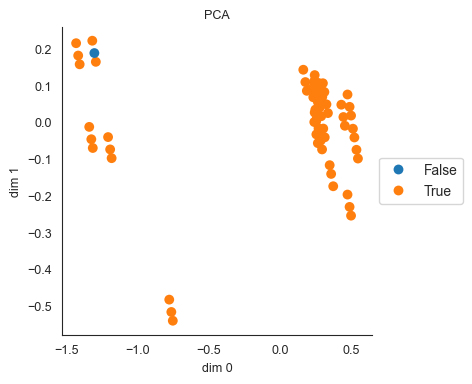

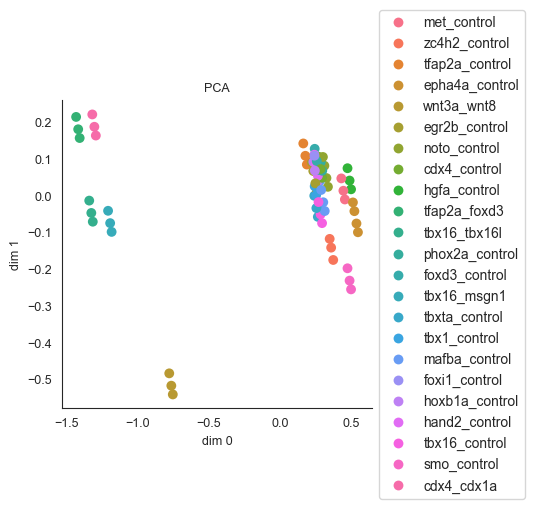

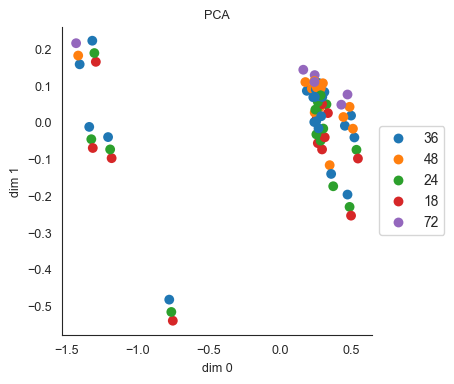

In [42]:
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="seen_during_training", circle_size=50)
df_condition_embedding["condition"] = df_condition_embedding.index
df_condition_embedding["genetic_perturbation"] = df_condition_embedding.apply(lambda x: "_".join(x["condition"].split("_")[:2]), axis=1)
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="genetic_perturbation", circle_size=50)
df_condition_embedding["time_point"] = df_condition_embedding.apply(lambda x: x["condition"].split("_")[-1], axis=1)
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="time_point", circle_size=50, legend=False)

In [43]:
covariate_data_train = adata_train[~adata_train.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])
covariate_data_test = adata_test[~adata_test.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])

df_embedding_train = cf_added.get_condition_embedding(covariate_data=covariate_data_train, condition_id_key="condition", rep_dict=adata_train.uns)[0]
df_embedding_test = cf_added.get_condition_embedding(covariate_data=covariate_data_test, condition_id_key="condition", rep_dict=adata_train.uns)[0]

df_embedding_train["seen_during_training"] = True
df_embedding_test["seen_during_training"] = False
df_condition_embedding = pd.concat((df_embedding_train, df_embedding_test))

100%|██████████| 1/1 [00:00<00:00, 558.64it/s]


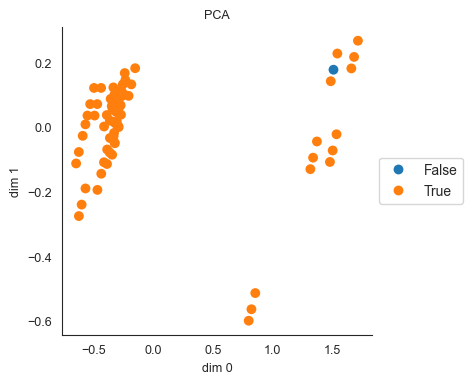

In [44]:
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="seen_during_training", circle_size=50)

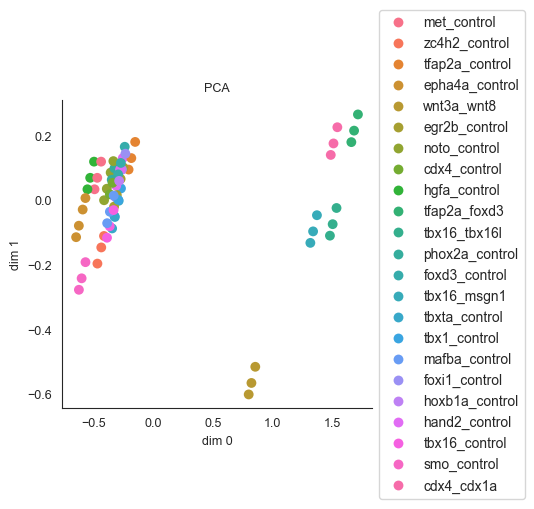

In [45]:
df_condition_embedding["condition"] = df_condition_embedding.index
df_condition_embedding["genetic_perturbation"] = df_condition_embedding.apply(lambda x: "_".join(x["condition"].split("_")[:2]), axis=1)
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="genetic_perturbation", circle_size=50)

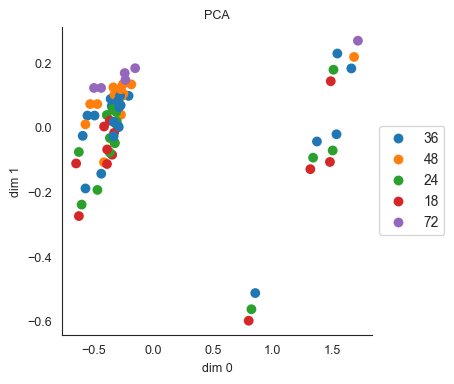

In [46]:
df_condition_embedding["time_point"] = df_condition_embedding.apply(lambda x: x["condition"].split("_")[-1], axis=1)
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="time_point", circle_size=50, legend=False)


## Predicting with CellFlow

Here, we want to predict the continuous development of the cdx4-cdx1a perturbed zebrafish. Hence, we need to create `covariate_data` which contains conditions corresponding to densely sampled time points.

In [47]:
covariate_data_test

,cell,Size_Factor,n.umi,perc_mitochondrial_umis,timepoint,Oligo,hash_umis,top_to_second_best_ratio,cell_type_sub,cell_type_broad,...,hash_plate,log.hash_umis,gene1+gene2,gene_target_1,gene_target_2,condition,is_control,first_t_control,logtime,germ_layer_adapted
C07_D06_P03-D07_LIG34,C07_D06_P03-D07_LIG34,2.287209,1039.0,0.192493,24.0,24h_cdx4-cdx1a_P12_A10,15.0,11.015797,"neuron (cranial ganglia sensory, Rohon-Beard)","neuron (cranial ganglia sensory, Rohon-Beard)",...,P12,1.176091,cdx4+cdx1a,cdx4,cdx1a,cdx4_cdx1a_24,False,False,3.178054,ectoderm_neural_crest


In [48]:
def duplicate_and_interpolate(df, column, start, end, steps):
    result = pd.DataFrame()
    
    for _, row in df.iterrows():
        new_rows = pd.DataFrame([row] * steps)  # Duplicate the row
        new_rows[column] = np.log(np.linspace(start, end, steps)) # Log-transform the time point
        result = pd.concat([result, new_rows], ignore_index=True)
    
    return result
    
covariate_data_interpolated = duplicate_and_interpolate(covariate_data_test, 'logtime', 18, 36, 10)
covariate_data_interpolated.loc[:, "condition"] = covariate_data_interpolated.apply(lambda x: "_".join([x.gene_target, str(int(np.round(np.exp(x.logtime))))]), axis=1)
covariate_data_interpolated.head()

,cell,Size_Factor,n.umi,perc_mitochondrial_umis,timepoint,Oligo,hash_umis,top_to_second_best_ratio,cell_type_sub,cell_type_broad,...,hash_plate,log.hash_umis,gene1+gene2,gene_target_1,gene_target_2,condition,is_control,first_t_control,logtime,germ_layer_adapted
0,C07_D06_P03-D07_LIG34,2.287209,1039.0,0.192493,24.0,24h_cdx4-cdx1a_P12_A10,15.0,11.015797,"neuron (cranial ganglia sensory, Rohon-Beard)","neuron (cranial ganglia sensory, Rohon-Beard)",...,P12,1.176091,cdx4+cdx1a,cdx4,cdx1a,cdx4_cdx1a_18,False,False,2.890372,ectoderm_neural_crest
1,C07_D06_P03-D07_LIG34,2.287209,1039.0,0.192493,24.0,24h_cdx4-cdx1a_P12_A10,15.0,11.015797,"neuron (cranial ganglia sensory, Rohon-Beard)","neuron (cranial ganglia sensory, Rohon-Beard)",...,P12,1.176091,cdx4+cdx1a,cdx4,cdx1a,cdx4_cdx1a_20,False,False,2.995732,ectoderm_neural_crest
2,C07_D06_P03-D07_LIG34,2.287209,1039.0,0.192493,24.0,24h_cdx4-cdx1a_P12_A10,15.0,11.015797,"neuron (cranial ganglia sensory, Rohon-Beard)","neuron (cranial ganglia sensory, Rohon-Beard)",...,P12,1.176091,cdx4+cdx1a,cdx4,cdx1a,cdx4_cdx1a_22,False,False,3.091042,ectoderm_neural_crest
3,C07_D06_P03-D07_LIG34,2.287209,1039.0,0.192493,24.0,24h_cdx4-cdx1a_P12_A10,15.0,11.015797,"neuron (cranial ganglia sensory, Rohon-Beard)","neuron (cranial ganglia sensory, Rohon-Beard)",...,P12,1.176091,cdx4+cdx1a,cdx4,cdx1a,cdx4_cdx1a_24,False,False,3.178054,ectoderm_neural_crest
4,C07_D06_P03-D07_LIG34,2.287209,1039.0,0.192493,24.0,24h_cdx4-cdx1a_P12_A10,15.0,11.015797,"neuron (cranial ganglia sensory, Rohon-Beard)","neuron (cranial ganglia sensory, Rohon-Beard)",...,P12,1.176091,cdx4+cdx1a,cdx4,cdx1a,cdx4_cdx1a_26,False,False,3.258097,ectoderm_neural_crest


In [ ]:
adata_ctrl = adata[(adata.obs["gene_target"]=="control_control") & (adata.obs["timepoint"]==18)]
preds = cf.predict(adata=adata_ctrl, sample_rep="X_aligned", condition_id_key="condition", covariate_data=covariate_data_interpolated)

100%|██████████| 10/10 [00:00<00:00, 833.34it/s]


In [ ]:
preds_added = cf_added.predict(adata=adata_ctrl, sample_rep="X_aligned", condition_id_key="condition", covariate_data=covariate_data_interpolated)

100%|██████████| 10/10 [00:00<00:00, 527.71it/s]


In [ ]:
preds

{'cdx4_cdx1a_18': array([[ 27.155325  , -36.251526  ,   1.4058505 , ...,  -0.6132335 ,
          -1.1320214 ,   1.1795441 ],
        [ 29.746485  , -34.44527   ,   2.445259  , ...,   0.2654465 ,
          -0.31749746,   0.6872492 ],
        [ 28.80741   , -35.415424  ,   0.7612896 , ...,   2.4045246 ,
          -0.17088033,   0.09212083],
        ...,
        [ 33.23815   , -39.82162   ,   3.3477008 , ...,   1.4414227 ,
          -1.4821451 ,  -2.3140688 ],
        [ 28.256903  , -34.33803   ,   2.7743142 , ...,  -0.9365683 ,
           0.3210371 ,  -0.9607075 ],
        [ 26.788733  , -33.32303   ,   4.707177  , ...,   0.6839025 ,
          -2.7484212 ,  -0.5231128 ]], shape=(332, 100), dtype=float32),
 'cdx4_cdx1a_20': array([[ 27.15252   , -36.253075  ,   1.4069046 , ...,  -0.61845714,
          -1.134925  ,   1.1825781 ],
        [ 29.746353  , -34.442684  ,   2.4451232 , ...,   0.26431128,
          -0.31266826,   0.6862776 ],
        [ 28.808596  , -35.418045  ,   0.7570051 , ...

In [ ]:
def get_adata_preds(preds):
    adata_preds = []
    for cond, array in preds.items():
    
        obs_data = pd.DataFrame({
         'condition': [cond] * array.shape[0]
        })
        adata_pred = ad.AnnData(X=np.empty((len(array),adata_train.n_vars)), obs=obs_data)
        adata_pred.obsm["X_aligned"] = np.squeeze(array)
        adata_preds.append(adata_pred)
    return adata_preds


cf_adata_preds = ad.concat(get_adata_preds(preds))
cf_adata_preds.var_names = adata_train.var_names

cf_added_adata_preds = ad.concat(get_adata_preds(preds_added))
cf_added_adata_preds.var_names = adata_train.var_names

In [ ]:
compute_wknn(ref_adata=adata, query_adata=cf_adata_preds, n_neighbors=1, ref_rep_key="X_aligned", query_rep_key="X_aligned")
transfer_labels(query_adata=cf_adata_preds, ref_adata=adata, label_key="cell_type_broad")

compute_wknn(ref_adata=adata, query_adata=cf_added_adata_preds, n_neighbors=1, ref_rep_key="X_aligned", query_rep_key="X_aligned")
transfer_labels(query_adata=cf_added_adata_preds, ref_adata=adata, label_key="cell_type_broad")

INFO     cuML is not installed or GPU is not available. Falling back to neighborhood estimation using CPU with     
         pynndescent.                                                                                              
INFO     cuML is not installed or GPU is not available. Falling back to neighborhood estimation using CPU with     
         pynndescent.                                                                                              
INFO     cuML is not installed or GPU is not available. Falling back to neighborhood estimation using CPU with     
         pynndescent.                                                                                              
INFO     cuML is not installed or GPU is not available. Falling back to neighborhood estimation using CPU with     
         pynndescent.                                                                                              


In [ ]:
df_pert_timepoint = cf_adata_preds.obs.groupby(["condition"])["cell_type_broad_transfer"].value_counts(normalize=True).to_frame(name="fraction").reset_index()
df_pert_timepoint["timepoint"] = df_pert_timepoint.apply(lambda x: x["condition"].split("_")[-1], axis=1)
df_pert_timepoint["condition"].unique()

array(['cdx4_cdx1a_18', 'cdx4_cdx1a_20', 'cdx4_cdx1a_22', 'cdx4_cdx1a_24',
       'cdx4_cdx1a_26', 'cdx4_cdx1a_28', 'cdx4_cdx1a_30', 'cdx4_cdx1a_32',
       'cdx4_cdx1a_34', 'cdx4_cdx1a_36'], dtype=object)

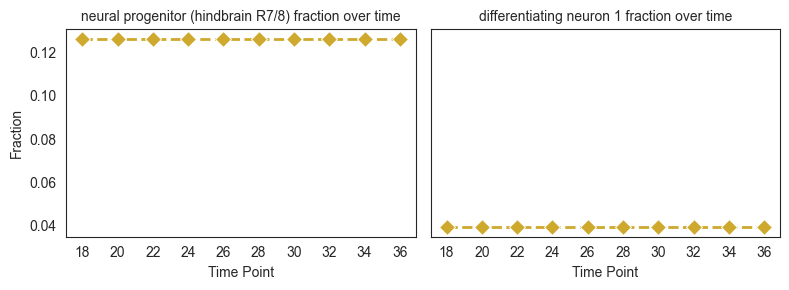

In [ ]:
cell_types = [
    ("neural progenitor (hindbrain R7/8)", "#CEA92D"),
    ("differentiating neuron 1", "#CEA92D")
]

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

for ax, (cell_type, color) in zip(axes, cell_types):
    data = df_pert_timepoint[df_pert_timepoint["cell_type_broad_transfer"] == cell_type]
    sns.lineplot(
        data=data,
        x="timepoint",
        y="fraction",
        marker="D",
        linestyle="--",
        linewidth=2,
        markersize=8,
        alpha=1.0,
        color=color,
        ax=ax
    )
    ax.set_title(f"{cell_type} fraction over time", fontsize=10)
    ax.set_xlabel("Time Point", fontsize=10)
    ax.set_ylabel("Fraction" if ax == axes[0] else "", fontsize=10)
    ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()


In [ ]:
df_pert_timepoint = cf_added_adata_preds.obs.groupby(["condition"])["cell_type_broad_transfer"].value_counts(normalize=True).to_frame(name="fraction").reset_index()
df_pert_timepoint["timepoint"] = df_pert_timepoint.apply(lambda x: x["condition"].split("_")[-1], axis=1)
df_pert_timepoint["condition"].unique()

array(['cdx4_cdx1a_18', 'cdx4_cdx1a_20', 'cdx4_cdx1a_22', 'cdx4_cdx1a_24',
       'cdx4_cdx1a_26', 'cdx4_cdx1a_28', 'cdx4_cdx1a_30', 'cdx4_cdx1a_32',
       'cdx4_cdx1a_34', 'cdx4_cdx1a_36'], dtype=object)

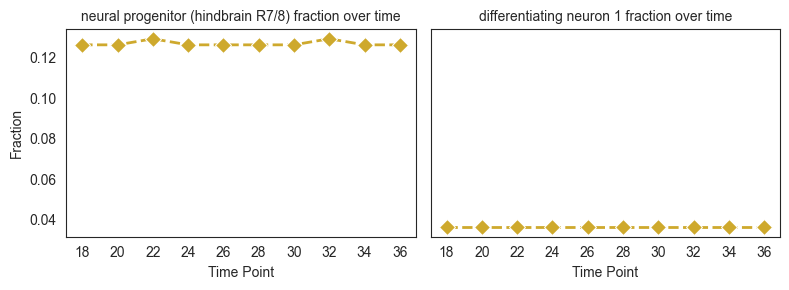

In [ ]:
cell_types = [
    ("neural progenitor (hindbrain R7/8)", "#CEA92D"),
    ("differentiating neuron 1", "#CEA92D")
]

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

for ax, (cell_type, color) in zip(axes, cell_types):
    data = df_pert_timepoint[df_pert_timepoint["cell_type_broad_transfer"] == cell_type]
    sns.lineplot(
        data=data,
        x="timepoint",
        y="fraction",
        marker="D",
        linestyle="--",
        linewidth=2,
        markersize=8,
        alpha=1.0,
        color=color,
        ax=ax
    )
    ax.set_title(f"{cell_type} fraction over time", fontsize=10)
    ax.set_xlabel("Time Point", fontsize=10)
    ax.set_ylabel("Fraction" if ax == axes[0] else "", fontsize=10)
    ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()
